In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 500

import os
print(os.listdir("../input"))

['test', 'train', 'train.csv', 'labels.csv', 'sample_submission.csv']


In [2]:
import glob
import json
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import gc

%matplotlib inline

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")
labels_df = pd.read_csv("../input/labels.csv")

In [4]:
print("[train]")
print(len(train_df))
print(Counter(map(lambda x: x.split(".")[-1], os.listdir("../input/train/"))))

print("[test]")
print(len(test_df))
print(Counter(map(lambda x: x.split(".")[-1], os.listdir("../input/test/"))))

[train]
109237
Counter({'png': 109237})
[test]
7443
Counter({'png': 7443})


## check labels

In [5]:
len(labels_df)

1103

tag        705
culture    398
Name: attribute_type, dtype: int64


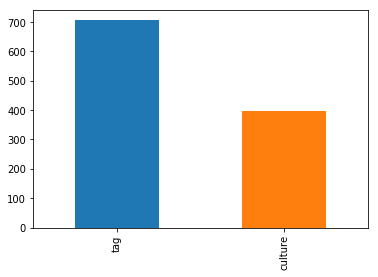

In [6]:
labels_df["attribute_type"] = labels_df.attribute_name.apply(lambda x: x.split("::")[0])
print(labels_df["attribute_type"].value_counts())
labels_df.attribute_type.value_counts().plot.bar()

In [7]:
labels_df.query("attribute_type == 'culture'").index 

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            388, 389, 390, 391, 392, 393, 394, 395, 396, 397],
           dtype='int64', length=398)

In [8]:
labels_df.query("attribute_type == 'tag'").index 

Int64Index([ 398,  399,  400,  401,  402,  403,  404,  405,  406,  407,
            ...
            1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102],
           dtype='int64', length=705)

In [9]:
labels_df[:398].head(10)

,attribute_id,attribute_name,attribute_type
0,0,culture::abruzzi,culture
1,1,culture::achaemenid,culture
2,2,culture::aegean,culture
3,3,culture::afghan,culture
4,4,culture::after british,culture
5,5,culture::after german,culture
6,6,culture::after german original,culture
7,7,culture::after italian,culture
8,8,culture::after russian original,culture
9,9,culture::akkadian,culture


In [10]:
labels_df[398:].head(10)

,attribute_id,attribute_name,attribute_type
398,398,tag::abbies,tag
399,399,tag::abraham,tag
400,400,tag::abstraction,tag
401,401,tag::acanthus,tag
402,402,tag::acorns,tag
403,403,tag::acrobats,tag
404,404,tag::actors,tag
405,405,tag::actresses,tag
406,406,tag::adam,tag
407,407,tag::admirals,tag


## check attibure_id's frequency in train

In [11]:
train_attr_ohot = np.zeros((len(train_df), len(labels_df)), dtype=int)

for idx, attr_arr in enumerate(train_df.attribute_ids.str.split(" ").apply(lambda l: list(map(int, l))).values):
    train_attr_ohot[idx, attr_arr] = 1

In [12]:
names_arr = labels_df.attribute_name.values
train_df["attribute_names"] = [", ".join(names_arr[arr == 1]) for arr in train_attr_ohot]

In [13]:
train_df["attr_num"] = train_attr_ohot.sum(axis=1)
train_df["culture_attr_num"] = train_attr_ohot[:, :398].sum(axis=1)
train_df["tag_attr_num"] = train_attr_ohot[:, 398:].sum(axis=1)

In [14]:
train_df.head()

,id,attribute_ids,attribute_names,attr_num,culture_attr_num,tag_attr_num
0,1000483014d91860,147 616 813,"culture::french, tag::dogs, tag::men",3,1,2
1,1000fe2e667721fe,51 616 734 813,"culture::british, tag::dogs, tag::horses, tag::men",4,1,3
2,1001614cb89646ee,776,tag::landscapes,1,0,1
3,10041eb49b297c08,51 671 698 813 1092,"culture::british, tag::flowers, tag::girls, tag::men, tag::women",5,1,4
4,100501c227f8beea,13 404 492 903 1093,"culture::american, tag::actors, tag::boys, tag::profiles, tag::working",5,1,4


## number of images by attribute

In [37]:
# count how many items per attribute and tag
counter = dict()

for k,v in train_df.iterrows():
    for an in v.attribute_names.split(','):
        an = an.strip()
        if an in counter.keys():
            counter[an]+= 1
        else:
            counter[an] = 1

In [67]:
s = pd.Series(counter, name='item_count')
df_attr_cnt = s.reset_index()
df_attr_cnt = df_attr_cnt.rename(columns={'index':'attribute'})
df_attr_cnt.head()

,attribute,item_count
0,culture::french,13522
1,tag::dogs,1278
2,tag::men,19970
3,culture::british,7615
4,tag::horses,1480


In [70]:
df_attr_cnt = df_attr_cnt.sort_values('item_count', ascending=False)
df_attr_cnt.head()

,attribute,item_count
2,tag::men,19970
8,tag::women,14281
0,culture::french,13522
14,culture::italian,10375
9,culture::american,9151


In [80]:
df_attr_cnt.tail()

,attribute,item_count
1080,culture::palermo,1
1078,culture::algerian,1
721,culture::freiburg im breisgau,1
986,culture::tsimshian,1
1102,culture::dehua,1


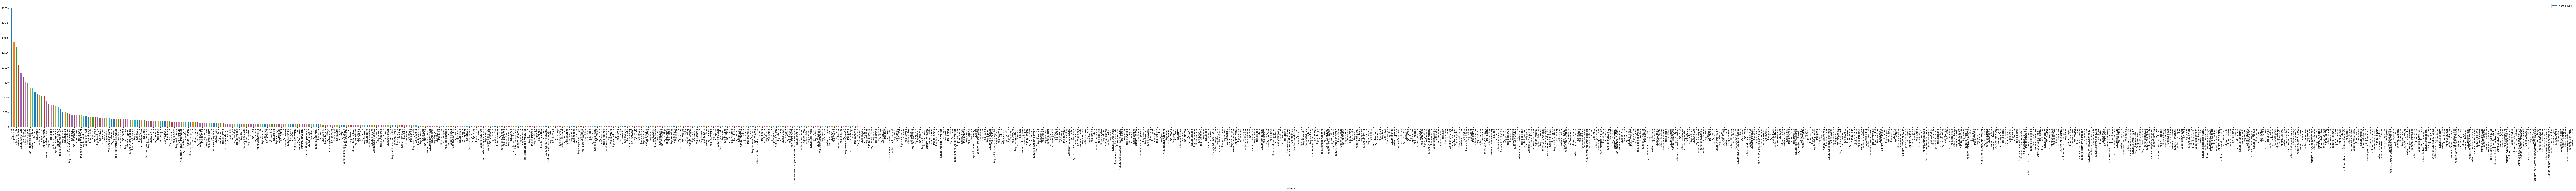

In [79]:
df_attr_cnt.plot(kind='bar',x='attribute', y='item_count', figsize=(200,5))

### number of attributes each art has

In [15]:
train_df.attr_num.value_counts().sort_index()

1      4324
2     37356
3     29200
4     20208
5     10946
6      6157
7       920
8       103
9        17
10        5
11        1
Name: attr_num, dtype: int64

### number of _"culture"_ attributes each art has

In [ ]:
train_df.culture_attr_num.value_counts().sort_index()

### number of _"tag"_ attributes each art has

In [ ]:
train_df.tag_attr_num.value_counts().sort_index()

### plots

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(3,1,1)
sns.countplot(train_df.attr_num,)
ax1.set_title("number of attributes each art has")
ax2 = fig.add_subplot(3,1,2,)
sns.countplot(train_df.culture_attr_num, ax=ax2)
ax2.set_title("number of 'culture' attributes each art has")
ax3 = fig.add_subplot(3,1,3,)
ax3.set_title("number of 'tag' attributes each art has")
sns.countplot(train_df.tag_attr_num, ax=ax3)

In [73]:
pd.pivot_table(
    train_df, index='culture_attr_num', columns='tag_attr_num', values='attr_num',
    aggfunc=len)

tag_attr_num,0,1,2,3,4,5,6,7,8,9
culture_attr_num,,,,,,,,,,
0,NaN,4112.0,3992.0,2133.0,1012.0,583.0,29.0,9.0,2.0,NaN
1,212.0,33357.0,24232.0,16594.0,8177.0,4913.0,155.0,30.0,7.0,2.0
2,7.0,2834.0,2490.0,2010.0,1085.0,698.0,32.0,7.0,2.0,1.0
3,1.0,112.0,151.0,111.0,53.0,32.0,NaN,1.0,NaN,NaN
4,NaN,25.0,19.0,5.0,7.0,3.0,NaN,NaN,NaN,NaN


In [74]:
train_df.culture_attr_num.value_counts(normalize=True).sort_index()

0    0.108681
1    0.802649
2    0.083909
3    0.004220
4    0.000540
Name: culture_attr_num, dtype: float64

In [75]:
train_df.tag_attr_num.value_counts(normalize=True).sort_index()

0    0.002014
1    0.370204
2    0.282725
3    0.190897
4    0.094602
5    0.057023
6    0.001977
7    0.000430
8    0.000101
9    0.000027
Name: tag_attr_num, dtype: float64

There is difference between the distribution of number of culture attributes and one of tag attributes.  

The number of _culture_ attributes 99% of arts have is 0 or 1 or 2, moreover, **80% is 1**.  
On the other hands, the number of _tag_ attributes shows a **gentler** slope from 1 to 5. Very few of arts have no tag attribute.

I think these observations may be useful for deciding thresholds ofclassifiers. 


Next, I show the arts which have many culuture or tag attributes. 

In [76]:
train_df.sort_values(by="culture_attr_num", ascending=False).head(15)

,id,attribute_ids,attribute_names,attr_num,culture_attr_num,tag_attr_num
20440,3cfdd60137c1b32,51 212 213 4 584 780,"culture::after british, culture::british, culture::london, culture::london original, tag::cups, tag::leaves",6,4,2
24219,451764f8a58d5a8d,43 51 213 4 782 974,"culture::after british, culture::birmingham, culture::british, culture::london original, tag::leopards, tag::shields",6,4,2
28079,4d8eb20869e8c8f9,43 51 213 4 487 835,"culture::after british, culture::birmingham, culture::british, culture::london original, tag::bottles, tag::mythical creatures",6,4,2
63082,9aceb772b5d0418d,15 51 212 1035 369,"culture::amsterdam, culture::british, culture::london, culture::turkish or venice, tag::textiles",5,4,1
51260,8073779393513ab,61 161 331 352 584 1069,"culture::campanian, culture::greek, culture::south italian, culture::teano, tag::cups, tag::vines",6,4,2
51138,80315eafcc925555,61 161 331 352 612 1069,"culture::campanian, culture::greek, culture::south italian, culture::teano, tag::dishes, tag::vines",6,4,2
55949,8ac7aa78a8c6c57a,51 156 171 744 1020 369,"culture::british, culture::german, culture::hilt, culture::turkish or venice, tag::inscriptions, tag::swords",6,4,2
64143,9d212036b5a497c4,61 161 331 352 584,"culture::campanian, culture::greek, culture::south italian, culture::teano, tag::cups",5,4,1
4633,1a36c73e2317845b,61 161 331 352 612 1069,"culture::campanian, culture::greek, culture::south italian, culture::teano, tag::dishes, tag::vines",6,4,2
83317,c7cd6ad639bb5269,43 51 213 4 420 515 780,"culture::after british, culture::birmingham, culture::british, culture::london original, tag::animals, tag::candlesticks, tag::leaves",7,4,3


In [77]:
train_df.sort_values(by="tag_attr_num", ascending=False).head(15)

,id,attribute_ids,attribute_names,attr_num,culture_attr_num,tag_attr_num
69600,a94284e9d464adfa,51 477 538 616 637 784 813 822 975 1092,"culture::british, tag::birds, tag::children, tag::dogs, tag::elephants, tag::lions, tag::men, tag::monkeys, tag::ships, tag::women",10,1,9
55029,88c7e0e377a69d27,92 477 519 616 671 734 813 912 1035 1092 369,"culture::coromandel coast, culture::turkish or venice, tag::birds, tag::carriages, tag::dogs, tag::flowers, tag::horses, tag::men, tag::rabbits, tag::textiles, tag::women",11,2,9
38081,63e46b86851b6bfe,51 420 519 573 733 734 813 923 971 1092,"culture::british, tag::animals, tag::carriages, tag::cows, tag::horse riding, tag::horses, tag::men, tag::rivers, tag::sheep, tag::women",10,1,9
103219,f33fe6b9a0ca3fb5,259 543 668 674 753 765 789 968 1092,"culture::netherlandish, tag::christianity, tag::fish, tag::food, tag::jesus, tag::kitchens, tag::lobsters, tag::servants, tag::women",9,1,8
103823,f4971da1b5331414,194 479 624 734 816 822 844 912 927,"culture::japan, tag::boars, tag::dragons, tag::horses, tag::mice, tag::monkeys, tag::netsuke, tag::rabbits, tag::roosters",9,1,8
81072,c2c5fa44fc7e6a69,541 595 773 808 932 941 1012 1072,"tag::christ, tag::death, tag::lamentation, tag::mary magdalene, tag::sadness, tag::saint john the evangelist, tag::suffering, tag::virgin mary",8,0,8
19749,3b779d8392e054a0,147 616 633 638 671 860 908 1035 1092,"culture::french, tag::dogs, tag::eagles, tag::emblems, tag::flowers, tag::owls, tag::putti, tag::textiles, tag::women",9,1,8
4625,1a311e499220e8cc,189 306 538 633 701 734 813 971 973 1092,"culture::italian, culture::rome, tag::children, tag::eagles, tag::goats, tag::horses, tag::men, tag::sheep, tag::shepherds, tag::women",10,2,8
57444,8e2e0a01c0d29af9,188 652 690 734 803 813 833 834 916,"culture::islamic, tag::fairies, tag::gardens, tag::horses, tag::manuscripts, tag::men, tag::musical instruments, tag::musicians, tag::reading",9,1,8
57414,8e19de49d1a7f416,418 541 581 777 808 813 983 1072,"tag::angels, tag::christ, tag::crucifixion, tag::last judgement, tag::mary magdalene, tag::men, tag::skeletons, tag::virgin mary",8,0,8


It is difficult for me to find somthing from these tables. Let's show images of arts in these tables.

In [ ]:
from PIL import Image

### arts with many _culture_ attributes

In [ ]:
fig = plt.figure(figsize=(5 * 5, 5 * 6))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df.sort_values(by="culture_attr_num", ascending=False)[["id", "attribute_names"]].values[:15]):
    ax = fig.add_subplot(5, 3, i // 3 * 3 + i % 3 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

### arts with many _tag_ attirbutes

In [ ]:
fig = plt.figure(figsize=(5 * 6, 5 * 5))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df.sort_values(by="tag_attr_num", ascending=False)[["id", "attribute_names"]].values[:15]):
    ax = fig.add_subplot(5, 3, i // 3 * 3 + i % 3 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

Since I have poor knowledge of art, cannot validate _culture_ attributes.

How about _tag_ attributes? They are relatively interpretable, but may be splitable into some types:

* objects painted (or carved) on arts: animals, humans, places, ...
* type of arts: 'cups', 'coat of arms', 'textiles'. 'dishes', 'vines'...
* special situations: 'nativity', 'last jugement', 'crucifixion',...
* actions: 'hourse riding', 'reading', 'suffering', ...
* ...

Therefore, I think it may be useful for classification to consider type of _tag_ attribute.
<br>
<br>
<br>
With respect to number, pictures tend to have more _tag_ attributes because of painted objects on them.  
I have one assumption that number of tag attributes depends on type of arts. Then, check several examples.

### arts with 1 _tag_ attribute

In [ ]:
fig = plt.figure(figsize=(5 * 8, 5 * 7))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df[train_df.tag_attr_num == 1][["id", "attribute_names"]].values[:49]):
    ax = fig.add_subplot(7, 7, i // 7 * 7 + i % 7 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

### arts with 2 _tag_ attributes

In [ ]:
fig = plt.figure(figsize=(5 * 8, 5 * 7))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df[train_df.tag_attr_num == 2][["id", "attribute_names"]].values[:49]):
    ax = fig.add_subplot(7, 7, i // 7 * 7 + i % 7 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

### arts with 3 _tag_ attributes

In [ ]:
fig = plt.figure(figsize=(5 * 8, 5 * 7))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df[train_df.tag_attr_num == 3][["id", "attribute_names"]].values[:49]):
    ax = fig.add_subplot(7, 7, i // 7 * 7 + i % 7 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

### arts with 4 _tag_ attributes

In [ ]:
fig = plt.figure(figsize=(5 * 8, 5 * 7))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df[train_df.tag_attr_num == 4][["id", "attribute_names"]].values[:49]):
    ax = fig.add_subplot(7, 7, i // 7 * 7 + i % 7 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

### arts with 5 _tag_ attributes

In [ ]:
fig = plt.figure(figsize=(5 * 8, 5 * 7))
fig.subplots_adjust(wspace=0.6, hspace=0.6)
for i, (art_id, attr_names) in enumerate(train_df[train_df.tag_attr_num == 5][["id", "attribute_names"]].values[:49]):
    ax = fig.add_subplot(7, 7, i // 7 * 7 + i % 7 + 1)
    im = Image.open("../input/train/{}.png".format(art_id))
    ax.imshow(im)
    im.close()
    attr_split = attr_names.split(", ")
    attr_culture = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:7] == "culture", attr_split)))
    attr_tag = list(map(lambda x: x.split("::")[-1], filter(lambda x: x[:3] == "tag", attr_split)))
    ax.set_title("art id: {}\nculture: {}\ntag: {}".format(art_id, attr_culture, attr_tag))

It seems that more _tag_ attributes arts have, more complex they are.

Most of arts with one _tag_ attributes are single objects such as ornaments.  
In contrast, most of arts with five ones are pictures or objects with complex design.

Maybe, we can predict number of _tag_ attributes by **_complexity_** of arts ?